# Second iteration of model - dynamic network

After some interactions a new link is formed between two random agents 

The first to be defined is a state space, here being set to be discrete values. 
Then the Agent class is defined to set an initial state and a method to "consider" it's state options and possibly changing it's state. 

In [1]:
states = [1, -1] #1 being cooperating, 0 being defecting
import random

class Agent:
    def __init__(self, state):
        self.state = state
        self.interactionsReceived = 0
        self.interactionsGiven = 0
    
    def consider(self, neighbour, neighboursWeight, politicalClimate):
        self.interactionsReceived +=1
        neighbour.addInteractionGiven()
        weight = self.state*0.8 + politicalClimate + defectorUtility + neighboursWeight*neighbour.state #+ random.uniform(-0.2, 0.2)
        
        #self.state = weight
        if(weight > 0):
            self.state = states[0]
        else:
            self.state = states[1]
    
    def addInteractionGiven(self):
        self.interactionsGiven +=1
        

In [2]:
def standardDeviation(fc):
    res = 4*fc*(1-fc)**3+24*(fc*(1-fc))**2+36*(1-fc)*fc**3+16*fc**4-16*fc**2
    return (res)

0.9899999999999993

In [72]:
from statistics import mean
import numpy as np

def correlation(model, depth):
    AgreeingNeighbours = [[0 for i in range(depth)] for j in range(len(model.graph))]
    
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
        parent = [nodeIdx]
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                    AgreeingNeighbours[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                    AgreeingNeighbours[nodeIdx][d] += 1
            for n in parent:
                nextLevelNeighs.discard(n) 
            parent = neighbours
            neighbours = nextLevelNeighs
            
    mat = np.matrix(AgreeingNeighbours)
    avg = mat.mean(axis=0)
    arrays = [[] for i in range(depth)]
    res = [0 for i in range(depth)]
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        for d in range(depth):
            for n in neighbours:
                arrays[d].append((AgreeingNeighbours[nodeIdx][d]-avg[0, d])*(AgreeingNeighbours[n][d]-avg[0, d]))
    for d in range(depth):
        res[d] = mean(arrays[d])
        
    return res

The model class consists of the agents and includes a method to make these interact. 

In [4]:
from numpy.random import choice
import random
import matplotlib.pyplot as plt
from statistics import stdev, mean
import imageio

class Model:
    def __init__(self):
        #Time dependent topology
        self.graph = nx.Graph()
        self.politicalClimate = 0.2
        self.ratio = []
        self.defectorDefectingNeighsList = []
        self.cooperatorDefectingNeighsList = []
        self.defectorDefectingNeighsSTDList = []
        self.cooperatorDefectingNeighsSTDList =[]
    
    def interact(self):
        nodeIndex = random.randint(0, len(self.graph) - 1)
        node = self.graph.nodes[nodeIndex]['agent']
        
        neighbours =  list(self.graph.adj[nodeIndex].keys())
        
        chosenNeighbourIndex = neighbours[random.randint(0, len(neighbours)-1)]
        chosenNeighbour = self.graph.nodes[chosenNeighbourIndex]['agent']
        
        weight = self.graph[nodeIndex][chosenNeighbourIndex]['weight']
        
        node.consider(chosenNeighbour, weight, self.politicalClimate)
        
    def getAvgNumberOfDefectorNeigh(self):
        defectorFriendsList = []
        defectorNeighboursList = []
        for node in self.graph:
            agreeingNeighbours = 0
            neighbours = list(self.graph.adj[node])
            for neighbourIndex in neighbours:
                if self.graph.nodes[neighbourIndex]['agent'].state == self.graph.nodes[node]['agent'].state:
                    agreeingNeighbours += 1
            if self.graph.nodes[node]['agent'].state== 1:
                defectorNeighboursList.append(agreeingNeighbours) #defectorNeighboursList.append(agreeingNeighbours/len(neighbours))
            else:
                defectorFriendsList.append(agreeingNeighbours)
        
        defectoravg = mean(defectorFriendsList)
        cooperatoravg =mean(defectorNeighboursList)
        defectorSTD = stdev(defectorFriendsList)
        cooperatorSTD =stdev(defectorNeighboursList)
        return(defectoravg, cooperatoravg, defectorSTD, cooperatorSTD)
                
    
    def countCooperatorRatio(self):
        count = 0
        for node in self.graph:
            if self.graph.nodes[node]['agent'].state > 0:
                count+=1
        return count/len(self.graph)
 
    def runSim(self, k, drawModel = False, countNeighbours = False, gifname=None):
        
        if(drawModel):
            draw_model(self)
            filenames = []
        
        if(countNeighbours):
            (defectorDefectingNeighs,
             cooperatorDefectingFriends,
             defectorDefectingNeighsSTD,
             cooperatorDefectingFriendsSTD) = self.getAvgNumberOfDefectorNeigh()
            print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
            print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
    
        for i in range(k):
            self.interact()
            ratio = self.countCooperatorRatio()
            self.ratio.append(ratio)
            #self.politicalClimate += (ratio-0.5)*0.001 #change the political climate depending on the ratio of cooperators
            
            if(countNeighbours):
                (defectorDefectingNeighs,
                 cooperatorDefectingNeighs,
                 defectorDefectingNeighsSTD,
                 cooperatorDefectingNeighsSTD) = self.getAvgNumberOfDefectorNeigh()
                self.defectorDefectingNeighsList.append(defectorDefectingNeighs)
                self.cooperatorDefectingNeighsList.append(cooperatorDefectingNeighs)
                self.defectorDefectingNeighsSTDList.append(defectorDefectingNeighsSTD)
                self.cooperatorDefectingNeighsSTDList.append(cooperatorDefectingNeighsSTD)
            if(drawModel and (i % 10 == 0)):
                draw_model(self, True, i)
                filenames.append("plot" + str(i) +".png")
                
            #if(i % 10 == 0):
                #a = random.randint(0,n)
                #b = random.randint(0,n)
                #while(a==b):
                    #b = random.randint(0,n)
                    #weight = random.uniform(0.1, 0.9)
                    #model.graph.add_edge(a, b, weight = weight)
        if(drawModel):
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave("network" +gifname+ ".gif", images, duration=0.04167)
       
    
        if(countNeighbours):
            drawDefectingNeighbours(self.defectorDefectingNeighsList,
                                    self.cooperatorDefectingNeighsList,
                                    self.defectorDefectingNeighsSTDList,
                                    self.cooperatorDefectingNeighsSTDList, 
                                    gifname)
        
        return self.ratio

In [5]:
import networkx as nx

def makeGridModel(n):
    model = Model()
    #weight = 0.5
    for i in range(n):
        for j in range (n):
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.add_node(i*n+j, agent=agent1, pos=(i, j))
            if(i!=0):
                weight = random.uniform(0.1, 0.9)
                model.graph.add_edge(i*n+j, (i-1)*n+j, weight = weight)
            if(j!=0):
                weight = random.uniform(0.1, 0.9)
                model.graph.add_edge(i*n+j, i*n+j-1, weight = weight)
    
    return model

In [6]:
import networkx as nx

def makeRandomModel(n, m):
    model = Model()
    model.graph = nx.barabasi_albert_graph(n, m)
    
    for n in range (n):
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.nodes[n]['agent'] = agent1
    
    return model

In [7]:
import matplotlib.pyplot as plt
from IPython.display import Image


def draw_model(model, save=False, filenumber = None):

    color_map = []
    pos = []
    for node in model.graph:
        pos.append(model.graph.nodes[node]['pos'])
        if model.graph.nodes[node]['agent'].state== 1:
            color_map.append('#03a45e')
        else: color_map.append('#f7796d')   
    
    plt.subplot(121)
    nx.draw(model.graph, pos, node_color = color_map, )
    if(save):
        plt.savefig("plot" + str(filenumber) +".png", bbox_inches="tight")


In [8]:
import matplotlib.pyplot as plt  
import numpy as np
  
def drawDefectingNeighbours(defectorDefectingNeighsList, cooperatorDefectingNeighsList, defectorDefectingNeighsSTDList, cooperatorDefectingNeighsSTDList, filname = None):
    steps = range(0, len(defectorDefectingNeighsList))
    defector = np.array( defectorDefectingNeighsList)
    defectorSTD = np.array( defectorDefectingNeighsSTDList)
    cooperator = np.array(cooperatorDefectingNeighsList)
    cooperatorSTD = np.array( cooperatorDefectingNeighsSTDList)
    
    # You typically want your plot to be ~1.33x wider than tall.  
    # Common sizes: (10, 7.5) and (12, 9)  
    plt.figure(figsize=(12, 9))  
    
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].set_title('Development of defector neighbours')
  
    # Remove the plot frame lines. They are unnecessary chartjunk.  
    #axarr[0] = plt.subplot(111)  
    #ax.spines["top"].set_visible(False)  
    #ax.spines["right"].set_visible(False)  
   
    #ax.get_xaxis().tick_bottom()  
    #ax.get_yaxis().tick_left()  
   
  
    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    plt.ylabel("avg number of defector friends", fontsize=12)  
  
    # Use matplotlib's fill_between() call to create error bars.    
    axarr[0].fill_between(steps, cooperator - cooperatorSTD,  
                 cooperator + cooperatorSTD,  color="#397c39")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[0].plot(steps, cooperatorDefectingNeighsList, color="white", lw=2) 
   
    axarr[1].fill_between(steps, defector - defectorSTD,  
                 defector + defectorSTD,  color="#7c393a")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[1].plot(steps, defectorDefectingNeighsList, color="white", lw=2) 
    
    #plt.title("Development of defector neighbours", fontsize=22)  
    
  
    # Finally, save the figure as a PNG.  
    # You can also save it as a PDF, JPEG, etc.  
    # Just change the file extension in this call.  
    # bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
    plt.savefig("avg" + filname +".png", bbox_inches="tight");
    
def drawSD(ratio, defectorDefectingNeighsSDList, cooperatorDefectingNeighsSDList):
    steps = range(0, len(defectorDefectingNeighsSDList))
    defectorSD = np.array( defectorDefectingNeighsSDList)
    cooperatorSD = np.array( cooperatorDefectingNeighsSDList)
    ratioArr = np.array(ratio)
    oppositeRatioArr = 1 - ratioArr
    #print(ratioArr, oppositeRatioArr)
    sd = standardDeviation(ratioArr)
    defsd = standardDeviation(oppositeRatioArr)
    #print(sd, defsd)
    
    plt.title("Estimated SD for random distribution - SD at all time steps ")
    plt.xlabel("Timesteps")
    plt.plot(steps, sd -cooperatorSD, color="#397c39")
    plt.plot(steps, defsd- defectorSD, color="#7c393a")

In [9]:
def simulate(n, k, **kwargs):
    model = makeGridModel(n)  
    ratio = model.runSim(k, **kwargs)
    return (model, ratio)

In [10]:
def batch_simulate(n,k,s):
    batch_proportions=[]
    #politicalClimate = 0.2
    
    for i in range(s):
        (model, proportion) = simulate(n, k)
        batch_proportions.append(proportion)
        print(model.politicalClimate)
    return batch_proportions 

## Radial Distribution function
Calculate the number of agreeing nodes per number of jumps out from the node

In [11]:
def radialDist(model, depth, isBefore):
    DefectorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    CooperatorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
        parent = [nodeIdx]
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                    CooperatorValues[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                    DefectorValues[nodeIdx][d] += 1
            CooperatorValues[nodeIdx][d] = CooperatorValues[nodeIdx][d]/len(neighbours)
            DefectorValues[nodeIdx][d] = DefectorValues[nodeIdx][d]/len(neighbours)
            
            #make sure the parent level isn't checked again
            for n in parent:
                nextLevelNeighs.discard(n) 

            parent = neighbours
            neighbours = nextLevelNeighs
     
    cooperatorRatio = model.countCooperatorRatio()
    
    cooperatorRes = []
    defectorRes = []
    for col in range(depth):
        coopSumRatios = 0
        defectSumRatios = 0
        for row in range(len(CooperatorValues)):
            coopSumRatios += CooperatorValues[row][col]
            defectSumRatios += DefectorValues[row][col]
        cooperatorRes.append(np.array(coopSumRatios)/(len(model.graph)*cooperatorRatio*cooperatorRatio))
        defectorRes.append(np.array(defectSumRatios)/(len(model.graph)*(1-cooperatorRatio)*(1-cooperatorRatio)))
    #print(cooperatorRes)
    if isBefore:
        intensity = 0.5
    else:
        intensity = 1
    plt.plot(range(1, len(cooperatorRes)+1), cooperatorRes, color=((23/255, 104/255, 37/255, intensity))) 
    plt.plot(range(1, len(cooperatorRes)+1), defectorRes, color=((109/255, 10/255, 10/255, intensity))) 

Defectors: avg:  1.7798165137614679  std:  0.8960592548728511
Cooperators: avg:  1.9310344827586208  std:  1.001947129829969


c:\users\sigrid\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


NameError: name 'defectorUtility' is not defined

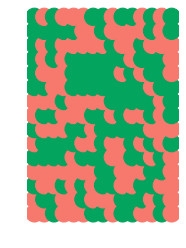

In [12]:

    model = makeGridModel(15)
    #radialDist(model, 12, True)
    #print(model.countCooperatorRatio())
    model.runSim(3000, drawModel=True, countNeighbours = True, gifname="network12")
    radialDist(model, 15, False)
    #print(model.countCooperatorRatio())
    


[0.55111111 0.55111111 0.55111111 ... 0.52444444 0.52444444 0.52444444] [0.44888889 0.44888889 0.44888889 ... 0.47555556 0.47555556 0.47555556]
[0.98955062 0.98955062 0.98955062 ... 0.99760988 0.99760988 0.99760988] [0.98955062 0.98955062 0.98955062 ... 0.99760988 0.99760988 0.99760988]


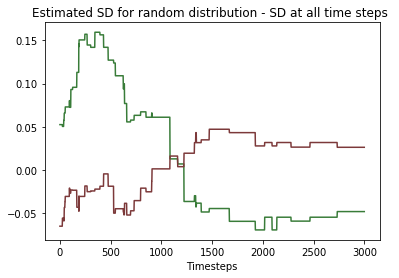

In [31]:
drawSD(model.ratio, model.defectorDefectingNeighsSTDList, model.cooperatorDefectingNeighsSTDList)


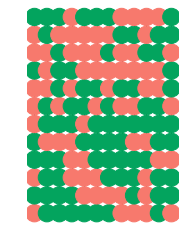

In [84]:
draw_model(model)

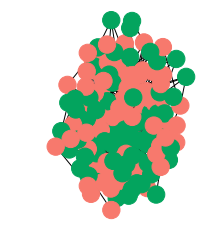

In [39]:
draw_model(model)


In [13]:
defectorUtility = -0.21 
 
politicalClimate=0.2 #Being environment-positive 

    
#(results) = batch_simulate(12, 2000,100)

#for i in results:
    #plt.plot(i)

[0.24810606060606058, 0.07395131874298538, 1.1512345679012344]


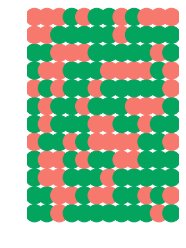

In [75]:
model = makeGridModel(12)
draw_model(model)
print(correlation(model, 3))
ratio = model.runSim(2000)

[0.273989898989899, 0.34515291806958476, 1.4809904601571267]


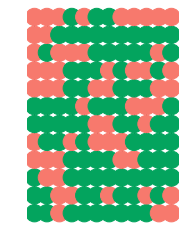

In [76]:
draw_model(model)
print(correlation(model, 3))

0.41
Defectors: avg:  0.7372881355932204  std:  0.2728159348725995
Cooperators: avg:  0.3882113821138211  std:  0.312144106286553


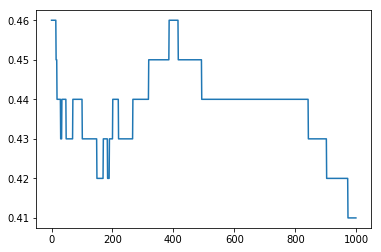

In [40]:
plt.plot(ratio)
print(model.countCooperatorRatio())
(defectorDefectingNeighs, cooperatorDefectingFriends, defectorDefectingNeighsSTD, cooperatorDefectingFriendsSTD)=model.getAvgNumberOfDefectorNeigh()
print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
        

[1, 12]


ZeroDivisionError: division by zero